# Assignment - Supervised Learning flow

# Part 1(a) Student details:
* Please write the First-Name, First letter of Last-Name and last 4 digits of the i.d. for each student. 

In [1]:
# stundent details example: John S. 9812
#student details 1: Or Z 9447



## Part 1(b) - Chat-GPT/other AI-agent/other assistance used:
* If you changed the prompt until you got a satisfying answer, please add all versions
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add information:

#### Add information in this Markdown cell (double click to change, shift-enter to view)
<pre>   
AI agent name:ChatGpt
Goal:
Propmpt1: Why do i need the use of display function?
    
Propmpt2:
    
Propmpt3: 

Other assistanse: Stack Overflow  
</pre>

## Part 1(c) - Learning Problem and dataset explaination.
* Please explain in one paragraph
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add explaining text:

#### Add information in this Markdown cell (double click to change, shift-enter to view)
<pre>
The assignment focuses on a binary classification problem, aiming to predict whether a Titanic passenger survived (Survived = 1) or did not survive (Survived = 0).
The dataset contains passenger-level information such as travel class, gender, age, family members aboard, ticket fare, and port of embarkation.
The training set is used for model development and hyperparameter tuning, while the test set serves to assess the model’s final performance and generate survival predictions.
    
</pre>

## Part 2 - Initial Preparations 
You could add as many code cells as needed


We start by loading the datasets of train and test into two objects and displaying the first 5 rows of each dataset.
In this section, we load the training and test CSV files into data frames and display their first five rows.
We then perform exploratory analysis to examine interesting relationships between features and how they may relate to survival.
The datasets are already clean and complete, with no missing values, so no additional data cleansing is required at this stage.


In [2]:
import pandas as pd            
import numpy as np             
import scipy as sp             
import matplotlib.pyplot as plt  
import seaborn as sns          
import bokeh                   
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer,precision_score,recall_score,confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold

train_df = pd.read_csv('dataset/titanic_train.csv')
test_df = pd.read_csv('dataset/titanic_test.csv')

display(train_df.head().add_prefix("train_"))
display(test_df.head().add_prefix("test_"))


,train_Pclass,train_Sex,train_Age,train_SibSp,train_Parch,train_Fare,train_Embarked,train_Survived
0,1,0,54.0,1,0,78.2667,1,1
1,2,0,45.0,0,0,13.5000,0,1
2,3,1,20.0,0,0,9.5000,0,0
3,3,1,36.0,0,0,7.8958,0,0
4,3,1,22.0,0,0,8.0500,0,0


,test_Pclass,test_Sex,test_Age,test_SibSp,test_Parch,test_Fare,test_Embarked,test_Survived
0,3,1,35.000000,0,0,7.0500,0,0
1,3,1,30.000000,0,0,7.2500,0,0
2,3,1,29.699118,0,0,14.5000,0,0
3,3,0,21.000000,0,0,7.7500,2,0
4,3,1,32.000000,0,0,56.4958,0,1


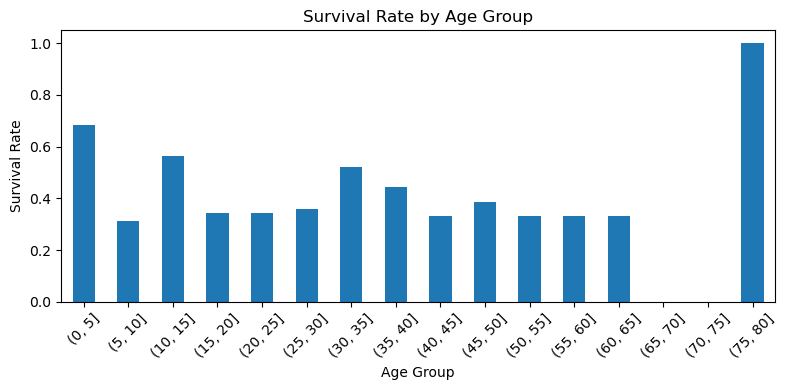

AgeBin
(0, 5]       38
(5, 10]      16
(10, 15]     16
(15, 20]     79
(20, 25]     99
(25, 30]    222
(30, 35]     71
(35, 40]     52
(40, 45]     36
(45, 50]     31
(50, 55]     21
(55, 60]     12
(60, 65]     12
(65, 70]      3
(70, 75]      3
(75, 80]      1
dtype: int64


In [3]:
#Showing the survival rate by the age of the passenger
bins = range(0, int(train_df['Age'].max()) + 5, 5)  
train_df['AgeBin'] = pd.cut(train_df['Age'], bins)

surv_by_agebin = train_df.groupby('AgeBin' , observed = False)['Survived'].mean()

fig, ax = plt.subplots(figsize=(8,4))
surv_by_agebin.plot(kind='bar', ax=ax)

ax.set_title("Survival Rate by Age Group")
ax.set_xlabel("Age Group")
ax.set_ylabel("Survival Rate")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Showing age disribiution by dividing it into ranges of 5 years
agebin_counts = train_df.groupby('AgeBin' , observed = False).size()

print(agebin_counts)

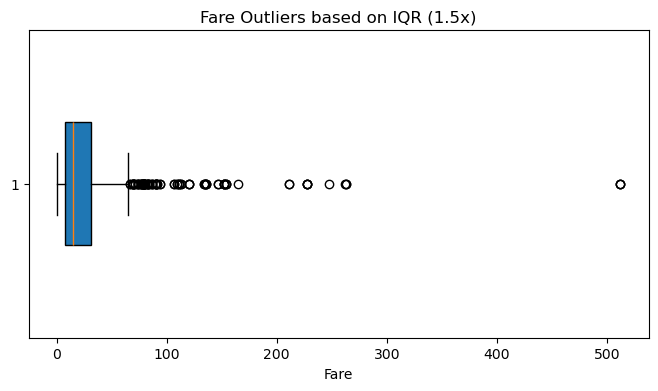

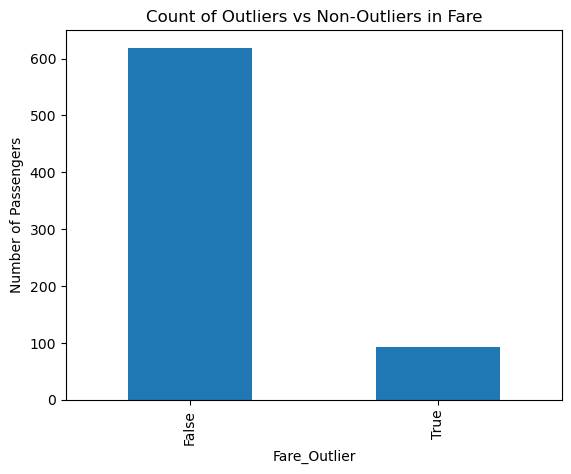

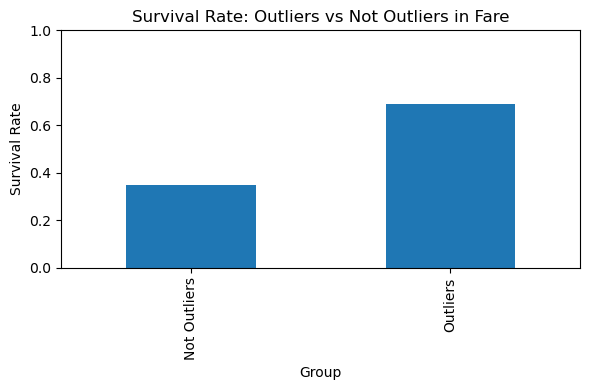

In [4]:
# Identifying Outliers in 'Fare' Using a Boxplot
# The boxplot uses the 1.5 × IQR rule by default to determine outliers.  
fig, ax = plt.subplots(figsize=(8,4))
ax.boxplot(train_df['Fare'].dropna(), vert=False, patch_artist=True, widths = 0.4)

ax.set_title("Fare Outliers based on IQR (1.5x)")
ax.set_xlabel("Fare")
plt.show()

#Displaying the outliers count according to 1.5 x IQR rule.
Q1 = train_df['Fare'].quantile(0.25)
Q3 = train_df['Fare'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

train_df['Fare_Outlier'] = ((train_df['Fare'] < lower_bound) | (train_df['Fare'] > upper_bound))

outlier_counts = train_df['Fare_Outlier'].value_counts()

outlier_counts.plot(kind="bar", title="Count of Outliers vs Non-Outliers in Fare")
plt.ylabel("Number of Passengers")
plt.show()

# Survival Rate Among Fare Outliers and Non-Outliers
surv_rate_by_outlier = train_df.groupby('Fare_Outlier')['Survived'].mean().rename({True: "Outliers", False: "Not Outliers"})
fig, ax = plt.subplots(figsize=(6,4))
surv_rate_by_outlier.plot(kind='bar', ax=ax)

ax.set_title("Survival Rate: Outliers vs Not Outliers in Fare")
ax.set_ylabel("Survival Rate")
ax.set_xlabel("Group")
ax.set_ylim(0,1)

plt.tight_layout()
plt.show()

## Part 3 - Experiments
You could add as many code cells as needed

In the following section we will conduct feature engineering to our features with three optional methods:

* Scaling (Standard, MinMax) – rescaling numeric features to a comparable scale, which is especially important for distance-based algorithms such as KNN.

* Feature Selection with correlation – dropping highly correlated features using Pearson correlation in order to reduce redundancy and avoid multicollinearity.

After preprocessing, we apply the K-Nearest Neighbors (KNN) classifier. We perform a Grid Search with Stratified 5-Fold Cross Validation in order to evaluate the model under different hyperparameter configurations:

* n_neighbors (number of neighbors to consider),

* weights (uniform vs. distance-based weighting),

* p (distance metric: Manhattan vs. Euclidean) 1 = Manhattan , 2 = Euclidean .

Each configuration is scored using the F1 score for the positive class (Survived=1).
All parameter combinations are evaluated, their mean CV F1 scores are reported, and the best setup is identified.

We then compare two scenarios:

* With Scaling and Feature Selection

* Without Scaling and Feature Selection

Finally, the best performing model is refit on the full training set and used to generate predictions for the test set. The results are saved into a submission file for further evaluatio


In [5]:
def feature_engineering(
    df: pd.DataFrame,
    scale_numeric: bool = False,
    scaling_method: str = "standard",
    use_corr_filter: bool = True,
    corr_threshold: float = 0.90,
    target_col: str = "Survived",
):

    # Copy dataset and identify numeric features (excluding the target)
    X = df.copy()
    num_cols = X.select_dtypes(include=["number"]).columns.tolist()
    X[num_cols] = X[num_cols].astype(float)

    # Apply feature scaling (Standard or MinMax) if requested
    if scale_numeric and num_cols:
        if scaling_method == "standard":
            scaler = StandardScaler()
        elif scaling_method == "minmax":
            scaler = MinMaxScaler()
        else:
            raise ValueError("scaling_method must be 'standard' or 'minmax'")
        X.loc[:, num_cols] = scaler.fit_transform(X[num_cols])

    # Drop highly correlated features based on Pearson correlation if requested
    if use_corr_filter and len(num_cols) > 1:
        corr = X[num_cols].corr().abs()
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        to_drop = [col for col in upper.columns if (upper[col] > corr_threshold).any()]
        if to_drop:
            X = X.drop(columns=to_drop)

    return X  # Return processed dataset


def print_all_results(search, title=""):
    # Print all parameter combinations with their mean CV F1 scores, then highlight the best
    print(f"\n=== {title} ===")
    for params, mean_score in zip(search.cv_results_["params"], search.cv_results_["mean_test_score"]):
        print(f"Params: {params}, Mean CV F1: {mean_score:.4f}")
    print("Best params:", search.best_params_)
    print("Best CV F1:", search.best_score_)


In [6]:
# Separate features and target
X = train_df.drop(columns=["Survived","AgeBin","Fare_Outlier"])
y = train_df["Survived"]

# Apply feature engineering with scaling and correlation-based selection
X_fe1 = feature_engineering(
    X,
    scale_numeric=True,
    scaling_method="standard",
    use_corr_filter=True
)

# Apply feature engineering without scaling and without correlation-based selection
X_fe2 = feature_engineering(
    X,
    scale_numeric=False,
    scaling_method="standard",
    use_corr_filter=False
)

# Define K-Nearest Neighbors classifier
knn = KNeighborsClassifier()

# Define hyperparameter search space for GridSearchCV
param_grid = {
    "n_neighbors": [3, 5, 7, 9],
    "weights": ["uniform", "distance"],
    "p": [1, 2]  # Distance metric: 1=Manhattan, 2=Euclidean
}

# Configure Stratified 5-Fold Cross Validation with F1 scoring
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score, pos_label=1)

# Run GridSearch with scaling and feature selection
search1 = GridSearchCV(knn, param_grid, scoring=scorer, cv=cv, n_jobs=-1)
search1.fit(X_fe1, y)

# Run GridSearch without scaling and feature selection
search2 = GridSearchCV(knn, param_grid, scoring=scorer, cv=cv, n_jobs=-1)
search2.fit(X_fe2, y)

# Print all parameter combinations and highlight best results for both scenarios
print_all_results(search1, "With Scaling and Feature Selection")
print_all_results(search2, "Without Scaling and Feature Selection")



=== With Scaling and Feature Selection ===
Params: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}, Mean CV F1: 0.7115
Params: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}, Mean CV F1: 0.7025
Params: {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}, Mean CV F1: 0.7100
Params: {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}, Mean CV F1: 0.7146
Params: {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}, Mean CV F1: 0.6978
Params: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}, Mean CV F1: 0.7062
Params: {'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}, Mean CV F1: 0.7122
Params: {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}, Mean CV F1: 0.7126
Params: {'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}, Mean CV F1: 0.7165
Params: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}, Mean CV F1: 0.7112
Params: {'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}, Mean CV F1: 0.7161
Params: {'n_neighbors': 7, 'p': 2, 'weights': 'distance'}, Mean CV F1: 0.7155
Params: {'n_neighbors': 9,

## Part 4 - Training 
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part (part 3)


In [7]:
# Decide which GridSearch won (With scaling and feature selection or without)
best_search = search1 if search1.best_score_ >= search2.best_score_ else search2
setup_name = "With Scaling and Feature Selection" if best_search is search1 else "Without Scaling and Feature Selection"

print(f"Best setup: {setup_name}")
print("Best parameters:", best_search.best_params_)

# Re-train a fresh KNN with the best parameters on the full training set
best_params = best_search.best_params_
best_model = KNeighborsClassifier(**best_params)

X_train_final = X_fe1 if best_search is search1 else X_fe2
best_model.fit(X_train_final, y)



Best setup: With Scaling and Feature Selection
Best parameters: {'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}


KNeighborsClassifier(n_neighbors=9, p=1)

## Part 5 - Apply on test and show model performance estimation

First 5 predictions on test: [0 0 0 1 0]
First 5 real values of test: [0 0 0 0 1]
Precision (class 1): 0.7200
Recall (class 1): 0.5902
F1-score (class 1): 0.6486


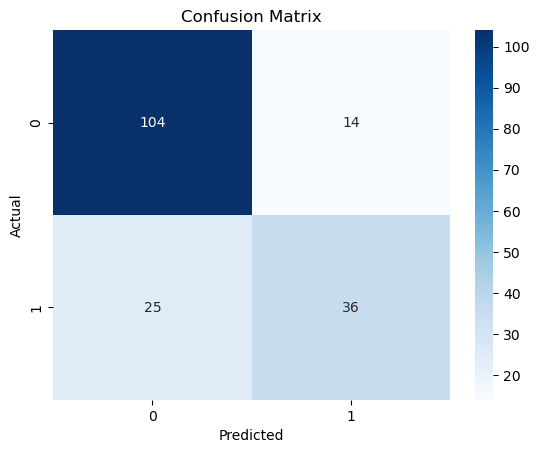

In [8]:
#Loading test set
y_test = test_df["Survived"].astype(int) 
X_test_raw = test_df.drop(columns=["Survived"])

#Predicting the label on test set.
y_test_pred = best_model.predict(X_test_raw)

print("First 5 predictions on test:", y_test_pred[:5])
print("First 5 real values of test:", y_test[:5].values)

#Presenting the results of F1, Recall and Precision and confusion matrix
if y_test is not None:
    prec = precision_score(y_test, y_test_pred, pos_label=1)
    rec = recall_score(y_test, y_test_pred, pos_label=1)
    f1 = f1_score(y_test, y_test_pred, pos_label=1) 
    print(f"Precision (class 1): {prec:.4f}")
    print(f"Recall (class 1): {rec:.4f}")
    print(f"F1-score (class 1): {f1:.4f}")
    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


